In [1]:
import pandas as pd
import sqlalchemy as sqla
from sqlalchemy import create_engine
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

In [2]:
URI = "dublinbike.c5ekejexdq4k.us-east-1.rds.amazonaws.com"
PORT = "3306"
DB = "dublin_bike"
USER = "admin"
PASSWARD = "group888"

engine = create_engine("mysql+mysqlconnector://{}:{}@{}:{}/{}".format(USER, PASSWARD, URI, PORT, DB))

In [3]:
df = pd.read_sql_table("bike_availibility", engine, parse_dates="True", index_col=0)
display(df.head())

,ID,Number,Time,Available_bike_stands,Available_bikes,Status
0,3083,42,2022-02-16 00:10:58,3,27,OPEN
1,3084,30,2022-02-16 00:10:58,17,3,OPEN
2,3085,54,2022-02-16 00:10:58,16,17,OPEN
3,3086,108,2022-02-16 00:10:58,19,16,OPEN
4,3087,56,2022-02-16 00:10:58,26,14,OPEN


(229460, 6)


<AxesSubplot:xlabel='Time', ylabel='Available_bikes'>

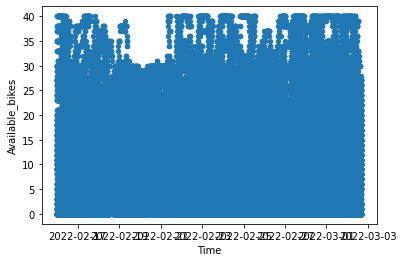

In [4]:
df.sort_values(by="Number").head
print(df.shape)
df.plot.scatter(x="Time", y = "Available_bikes")

/var/folders/rf/mclkwt4528d_9wmdvyfrz0680000gn/T/ipykernel_45143/1650755299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_1["log"] = np.log(station_1["Available_bikes"])


,Time,Available_bikes,log
0,2022-02-16 00:10:58,27,3.295837
110,2022-02-16 00:20:57,27,3.295837
220,2022-02-16 00:31:55,27,3.295837
330,2022-02-16 00:41:54,28,3.332205
440,2022-02-16 00:51:26,28,3.332205


(2086, 3)


<AxesSubplot:xlabel='Time', ylabel='log'>

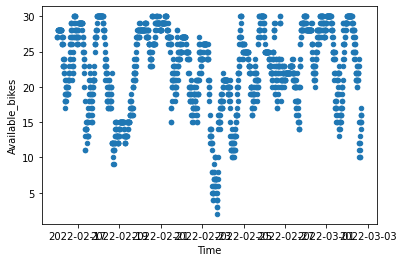

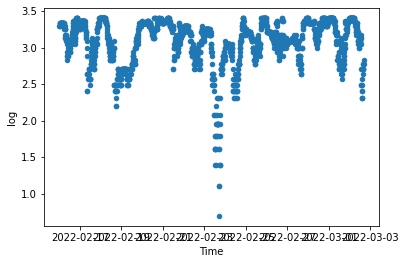

In [5]:
station_1 = df[df["Number"] == 42]
station_1["log"] = np.log(station_1["Available_bikes"]) 
station_1_test = station_1[["Time", "Available_bikes", "log"]]
display(station_1_test.head())
print(station_1_test.shape)
station_1_test.plot.scatter(x = "Time", y = "Available_bikes")
station_1_test.plot.scatter(x = "Time", y = "log")


,Time,Available_bikes
1,2022-02-16 00:10:58,3
111,2022-02-16 00:20:57,3
221,2022-02-16 00:31:55,3
331,2022-02-16 00:41:54,3
441,2022-02-16 00:51:26,3


(2086, 2)


<AxesSubplot:xlabel='Time', ylabel='Available_bikes'>

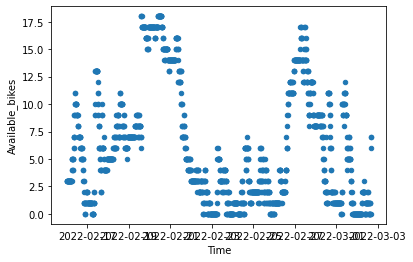

In [6]:
station_2 = df[df["Number"] == 30]
station_2_test = station_2[["Time", "Available_bikes"]]
display(station_2_test.head())
print(station_2_test.shape)
station_2_test.plot.scatter(x = "Time", y = "Available_bikes")

In [7]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(station_1_test['Available_bikes'], autolag = "AIC")
print("P-value", dftest[1])

P-value 0.0007292230401395991


/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


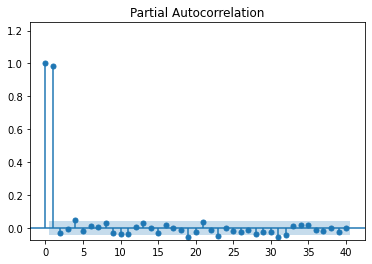

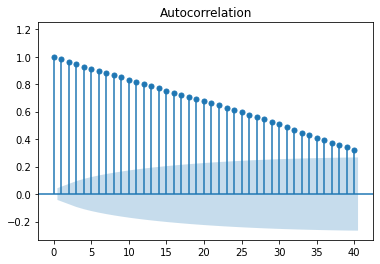

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(station_1_test["Available_bikes"], lags = 40, auto_ylims=True)
acf = plot_acf(station_1_test["Available_bikes"], lags = 40, auto_ylims=True)

In [9]:
import math
X = station_1_test["Available_bikes"].values
train = X[:math.ceil(len(station_1_test) * (2/3))]
test = X[math.ceil(len(station_1_test) * (2/3)):]
Y = station_1_test["log"].values
train1 = Y[:len(station_1_test) - 288 - 1]
test1 = Y[len(station_1_test) - 288 - 1:]


In [10]:
model = AutoReg(train, lags = 5).fit()
logmodel = AutoReg(train1, lags = 5).fit()
print(model.summary())


                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1391
Model:                     AutoReg(5)   Log Likelihood               -1983.833
Method:               Conditional MLE   S.D. of innovations              1.012
Date:                Wed, 02 Mar 2022   AIC                           3981.667
Time:                        16:33:24   BIC                           4018.306
Sample:                             5   HQIC                          3995.370
                                 1391                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3147      0.103      3.069      0.002       0.114       0.516
y.L1           1.0132      0.027     37.665      0.000       0.960       1.066
y.L2           0.0225      0.038      0.588      0.5

In [11]:
pred = model.predict(start= len(train), end = len(X) - 1, dynamic=False)
pred2 = logmodel.predict(start= len(train1), end = len(X) - 1, dynamic=False)

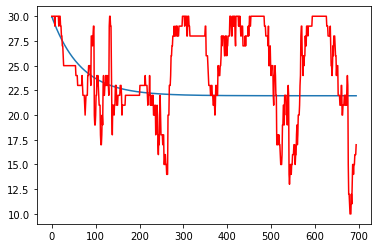

In [12]:
plt.plot(pred)
plt.plot(test, color = 'red')

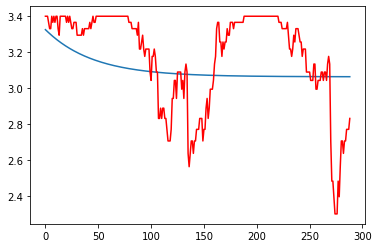

In [13]:
plt.plot(pred2)
plt.plot(test1, color = 'red')